In [0]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
!pip install mpl-finance
!pip install xgboost
!pip install feature_selector
!pip install lightgbm
!pip install --upgrade numpy
!pip install --upgrade pandas

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/21_4
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/21_4
'Copy of dubug.ipynb'			  data_preprocessing.py
'Copy of feature_selection_debug.ipynb'


In [2]:
import numpy as np
import pandas as pd
import talib
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import xgboost as xgb
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix
from sklearn.model_selection import KFold 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Dropout,LSTM
from data_preprocessing import *

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [0]:
feature_list = ['<OPEN>', 'Std_dev', 'RSI', 'Williams %R', 'MACD', 'SAR', 'CCI', 'ADX', 'ADXR', 'AROONDOWN', 
                'AROONUP', 'AROONOSC', 'BOP', 'DX', 'MACDSIGNALEXT', 'MACDHISTEXT', 'MACDHISTFIX', 'MINUS_DI',
                'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'STOCHRSIFASTK', 'STOCHRSIFASTD', 'TRIX', 'ULTOSC']


In [14]:
# You may want to change the path here
path = "/content/drive/My Drive/21_4/"
file = path + "AUDUSD.txt"

X,y=get_XY_data(file, "1D", "SHORTLINE",14,feature_list)



/content/drive/My Drive/21_4/data_preprocessing.py:339: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  new_test_df["pattern"] = all_idx
/content/drive/My Drive/21_4/data_preprocessing.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  new_test_df["label"] = la
/content/drive/My Drive/21_4/data_preprocessing.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [15]:
print(X.shape)
print(y.shape)

print("y's shape: ",y.shape)
print("number of class 0: ",y[y==0].shape)
print("number of class 1: ",y[y==1].shape)

# To ensure the X and y have the same amount
assert(y.shape[0] == X.shape[0])

# To ensure only have two class in y
assert(y.shape[0] == y[y==0].shape[0] + y[y==1].shape[0])


(1193, 26)
(1193,)
y's shape:  (1193,)
number of class 0:  (552,)
number of class 1:  (641,)


# Random Forest

In [22]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)


#preprocessing
scaler = StandardScaler()
#     scaler = Normalizer()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#model
clf = RandomForestClassifier(n_estimators=150, max_depth = None, max_features = "auto")
clf.fit(X_train, y_train)

#prediction
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro') 
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# print(accuracy)
print("accuracy is :",accuracy)
print("precision is :",precision)
print("recall : ",recall)
# print((tn, fp, fn, tp))
# print(cm)



accuracy is : 0.799163179916318
precision is : 0.7990384615384616
recall :  0.795877378435518


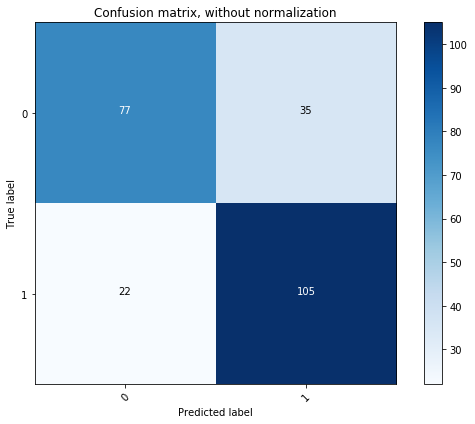

In [7]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                          title='Confusion matrix, without normalization')


plt.show()

# XGBOOST

In [0]:
param = {}
param['objective'] = 'multi:softmax'

param['num_class'] = 2
param["subsample"] = 1
param["colsample_bytree"] = 0.8
param["eval_metric"] = 'merror'
param['silent'] = 1

param['tree_method'] = 'gpu_hist'

# number of trees



0.3 15 0.2 150
accuracy is : 0.791
precision is : 0.791
recall :  0.79


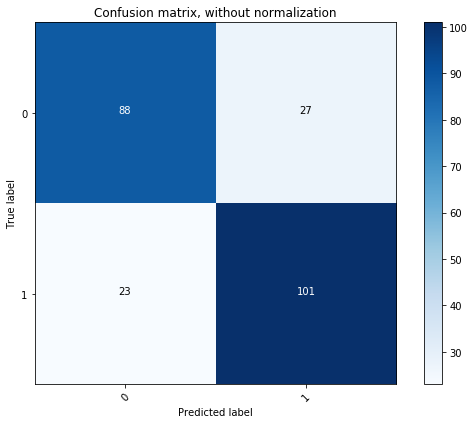

In [9]:
param['eta'] = 0.3
param['max_depth'] = 15
param['rate_drop'] = 0.2
num_round = 150

for i in range(1):
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

    #preprocessing
    scaler = StandardScaler()
    #     scaler = Normalizer()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #model
    dtest = xgb.DMatrix(X_test, label=y_test)
    x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dval = xgb.DMatrix(x_valid, label=y_valid)
    evallist = [(dtrain, 'train'),(dval, 'validation')]

    #prediction
    bst = xgb.train(param, dtrain, num_round, evallist,verbose_eval=False)
    y_pred = bst.predict(dtest)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro') 
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # print(accuracy)
    print(param['eta'], param['max_depth'],param['rate_drop'],num_round)
    print("accuracy is :",round(accuracy,3))
    print("precision is :",round(precision,3))
    print("recall : ",round(recall,3))
    # print((tn, fp, fn, tp))
    # print(cm)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(8,6))
    plot_confusion_matrix(cnf_matrix, classes=[0,1],
                          title='Confusion matrix, without normalization')


    plt.show()

# SVM

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2)

    
#preprocessing
scaler = StandardScaler()
#     scaler = Normalizer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#model
clf = svm.SVC(decision_function_shape='ovr')
clf.fit(X_train, y_train) 

#prediction
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro') 
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# print(accuracy)
print("accuracy is :",accuracy)
print("precision is :",precision)
print("recall : ",recall)
print((tn, fp, fn, tp))
print(cm)

accuracy is : 0.7364016736401674
precision is : 0.7379629629629629
recall :  0.7342917251051893
(78, 37, 26, 98)
[[78 37]
 [26 98]]


# MLP

In [12]:


#to_categorical

y_cat = to_categorical(y, num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2)
#preprocessing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X.shape[1],)),
    
    keras.layers.Dense(64),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(64),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(256),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(256),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(512),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(512),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.fit(X_train, y_train, batch_size=128,epochs=20)

#prediction
y_cat_pred = model.predict(X_test)
y_pred = np.argmax(y_cat_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro') 
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# print(accuracy)
print("accuracy is :",accuracy)
print("precision is :",precision)
print("recall : ",recall)
print((tn, fp, fn, tp))
print(cm)

W0626 06:24:55.162135 139927968475008 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/20
954/954 [==============================] - 1s 1ms/sample - loss: 1.0295 - acc: 0.4853
Epoch 2/20
954/954 [==============================] - 0s 80us/sample - loss: 1.0324 - acc: 0.4969
Epoch 3/20
954/954 [==============================] - 0s 83us/sample - loss: 0.9157 - acc: 0.5566
Epoch 4/20
954/954 [==============================] - 0s 85us/sample - loss: 0.8915 - acc: 0.5566
Epoch 5/20
954/954 [==============================] - 0s 94us/sample - loss: 0.8413 - acc: 0.5744
Epoch 6/20
954/954 [==============================] - 0s 79us/sample - loss: 0.7926 - acc: 0.5818
Epoch 7/20
954/954 [==============================] - 0s 82us/sample - loss: 0.8360 - acc: 0.5692
Epoch 8/20
954/954 [==============================] - 0s 88us/sample - loss: 0.7550 - acc: 0.6164
Epoch 9/20
954/954 [==============================] - 0s 79us/sample - loss: 0.7372 - acc: 0.6384
Epoch 10/20
954/954 [==============================] - 0s 78us/sample - loss: 0.7470 - acc: 0.6237
Epoch 11/20
954/954 

# LSTM

In [13]:


y_cat = to_categorical(y, num_classes=2)



X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train = X_train.reshape(-1,X_train.shape[1],1)
X_test = X_test.reshape(-1,X_test.shape[1],1)



model = keras.Sequential([
    keras.layers.LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1],1)),
    keras.layers.Dropout(0.2),
    
    keras.layers.LSTM(units = 128, return_sequences = True),
    keras.layers.Dropout(0.2),
    
    keras.layers.LSTM(units = 128, return_sequences = True),
    keras.layers.Dropout(0.2),
    
    keras.layers.LSTM(units = 128, return_sequences = True),
    keras.layers.Dropout(0.2),
    
    keras.layers.LSTM(units = 128, return_sequences = True),
    keras.layers.Dropout(0.2),
    
    keras.layers.LSTM(units = 128, return_sequences = True),
    keras.layers.Dropout(0.2),
    
    Flatten(),
    
    keras.layers.Dense(256),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(256),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.fit(X_train, y_train, epochs = 15, batch_size = 256)

#prediction
y_cat_pred = model.predict(X_test)
y_pred = np.argmax(y_cat_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro') 
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# print(accuracy)
print("accuracy is :",accuracy)
print("precision is :",precision)
print("recall : ",recall)
print((tn, fp, fn, tp))
print(cm)

W0626 06:25:09.602175 139927968475008 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/15
954/954 [==============================] - 4s 4ms/sample - loss: 0.8349 - acc: 0.6143
Epoch 2/15
954/954 [==============================] - 1s 1ms/sample - loss: 0.8171 - acc: 0.6363
Epoch 3/15
954/954 [==============================] - 1s 1ms/sample - loss: 0.7640 - acc: 0.6153
Epoch 4/15
954/954 [==============================] - 1s 1ms/sample - loss: 0.7388 - acc: 0.6394
Epoch 5/15
954/954 [==============================] - 1s 1ms/sample - loss: 0.7210 - acc: 0.6593
Epoch 6/15
954/954 [==============================] - 1s 1ms/sample - loss: 0.7223 - acc: 0.6415
Epoch 7/15
954/954 [==============================] - 1s 1ms/sample - loss: 0.7054 - acc: 0.6509
Epoch 8/15
954/954 [==============================] - 1s 1ms/sample - loss: 0.6726 - acc: 0.6520
Epoch 9/15
954/954 [==============================] - 1s 1ms/sample - loss: 0.6593 - acc: 0.6740
Epoch 10/15
954/954 [==============================] - 1s 1ms/sample - loss: 0.6673 - acc: 0.6468
Epoch 11/15
954/954 [========